In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from datetime import datetime
import tqdm

# Import our custom modules
from ann import NeuralNetwork
from pso import PSO
from pso_ann_trainer import rmse, create_fitness_function, to_numpy

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All imports successful!")

✅ All imports successful!


## Section 1: Load Data

In [55]:
# Load data
repo_root = Path.cwd().parent  # Go up one level from src to repo root
data_dir = repo_root / 'data'
npz_path = data_dir / 'processed_data.npz'

print(f"📂 Loading data from {npz_path}...")
data = np.load(npz_path, allow_pickle=True)
X_train = to_numpy(data['X_train'])
X_test = to_numpy(data['X_test'])
y_train = to_numpy(data['y_train']).ravel()
y_test = to_numpy(data['y_test']).ravel()

print(f"✓ Training data: {X_train.shape}")
print(f"✓ Test data: {X_test.shape}")
print(f"✓ n_features: {X_train.shape[1]}")

📂 Loading data from /Users/gayathridinesh/Documents/GitHub/F21BC_Coursework/data/processed_data.npz...
✓ Training data: (824, 8)
✓ Test data: (206, 8)
✓ n_features: 8


## Section 2: Define Experiment Configurations

10 experiments with varying PSO and ANN parameters

In [56]:
n_features = X_train.shape[1]

experiment_configs = [
    {
        "exp_id": 1,
        "seed": 42,
        "layer_sizes": [n_features, 64, 1],
        "activations": ['relu', 'linear'],
        "pso_swarm_size": 20,
        "pso_iterations": 40,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 2,
        "seed": 123,
        "layer_sizes": [n_features, 128, 32, 1],
        "activations": ['relu', 'relu', 'linear'],
        "pso_swarm_size": 25,
        "pso_iterations": 50,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 3,
        "seed": 456,
        "layer_sizes": [n_features, 64, 64, 1],
        "activations": ['relu', 'relu', 'linear'],
        "pso_swarm_size": 30,
        "pso_iterations": 45,
        "pso_bounds": (-3.0, 3.0)
    },
    {
        "exp_id": 4,
        "seed": 789,
        "layer_sizes": [n_features, 32, 1],
        "activations": ['relu', 'linear'],
        "pso_swarm_size": 15,
        "pso_iterations": 40,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 5,
        "seed": 999,
        "layer_sizes": [n_features, 256, 128, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 35,
        "pso_iterations": 60,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 6,
        "seed": 111,
        "layer_sizes": [n_features, 96, 48, 1],
        "activations": ['relu', 'relu', 'linear'],
        "pso_swarm_size": 25,
        "pso_iterations": 50,
        "pso_bounds": (-4.0, 4.0)
    },
    {
        "exp_id": 7,
        "seed": 222,
        "layer_sizes": [n_features, 128, 1],
        "activations": ['relu', 'linear'],
        "pso_swarm_size": 20,
        "pso_iterations": 45,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 8,
        "seed": 333,
        "layer_sizes": [n_features, 80, 40, 20, 1],
        "activations": ['relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 28,
        "pso_iterations": 55,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 9,
        "seed": 444,
        "layer_sizes": [n_features, 64, 32, 16, 1],
        "activations": ['relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 25,
        "pso_iterations": 50,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 10,
        "seed": 555,
        "layer_sizes": [n_features, 200, 100, 1],
        "activations": ['relu', 'relu', 'linear'],
        "pso_swarm_size": 30,
        "pso_iterations": 60,
        "pso_bounds": (-5.0, 5.0)
    }
]

print(f"📋 Configured {len(experiment_configs)} experiments")
for cfg in experiment_configs:
    print(f"  Exp {cfg['exp_id']}: layers={cfg['layer_sizes']}, swarm={cfg['pso_swarm_size']}, iters={cfg['pso_iterations']}")

📋 Configured 10 experiments
  Exp 1: layers=[8, 64, 1], swarm=20, iters=40
  Exp 2: layers=[8, 128, 32, 1], swarm=25, iters=50
  Exp 3: layers=[8, 64, 64, 1], swarm=30, iters=45
  Exp 4: layers=[8, 32, 1], swarm=15, iters=40
  Exp 5: layers=[8, 256, 128, 32, 1], swarm=35, iters=60
  Exp 6: layers=[8, 96, 48, 1], swarm=25, iters=50
  Exp 7: layers=[8, 128, 1], swarm=20, iters=45
  Exp 8: layers=[8, 80, 40, 20, 1], swarm=28, iters=55
  Exp 9: layers=[8, 64, 32, 16, 1], swarm=25, iters=50
  Exp 10: layers=[8, 200, 100, 1], swarm=30, iters=60


## Section 3: Utility Functions for RMSE and Experiment Execution

In [57]:
def run_single_experiment(config, X_train, X_test, y_train, y_test):
    """Run a single PSO-ANN experiment."""
    exp_id = config['exp_id']
    seed = config['seed']
    
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Create network
    net = NeuralNetwork(config['layer_sizes'], config['activations'])
    n_params = net.get_parameter_count()
    
    # Calculate initial RMSE
    y_pred_init = net.predict(X_train)
    if y_pred_init.ndim > 1:
        y_pred_init = y_pred_init.ravel()
    rmse_init = rmse(y_train, y_pred_init)
    
    # Create fitness function
    fitness_func = create_fitness_function(net, X_train, y_train)
    
    # Run PSO
    # Use bounds scaled by network size for better convergence
    # Larger networks may need smaller bounds to prevent divergence
    bound_scale = 1.0 / np.sqrt(n_params)
    bound_scale = np.clip(bound_scale, 0.5, 2.0)  # Keep within reasonable range
    
    pso = PSO(
        objective_function=fitness_func,
        dimension=n_params,
        swarm_size=config['pso_swarm_size'],
        num_informants=3,
        w=0.7,  # Slightly reduced inertia for better convergence
        c1=1.5,  # Slightly tuned cognitive component
        c2=1.5,  # Slightly tuned social component
        bounds=(-bound_scale, bound_scale),  # Adaptive bounds based on network size
        max_iterations=config['pso_iterations']
    )
    
    best_params, best_fitness, fitness_history = pso.optimize(verbose=False)
    
    # DEBUG: Print optimization info
    print(f"\n🔍 DEBUG INFO FOR EXPERIMENT {exp_id}:")
    print(f"Initial RMSE: {rmse_init:.4f}")
    print(f"PSO best fitness (final): {best_fitness:.4f}")
    print(f"Fitness history - First 5 iterations: {[f'{x:.4f}' for x in fitness_history[:5]]}")
    print(f"Fitness history - Last 5 iterations: {[f'{x:.4f}' for x in fitness_history[-5:]]}")
    
    # Apply best parameters and evaluate
    net.set_parameters(best_params)
    y_pred_train = net.predict(X_train)
    if y_pred_train.ndim > 1:
        y_pred_train = y_pred_train.ravel()
    rmse_train = rmse(y_train, y_pred_train)
    
    y_pred_test = net.predict(X_test)
    if y_pred_test.ndim > 1:
        y_pred_test = y_pred_test.ravel()
    rmse_test = rmse(y_test, y_pred_test)
    
    improvement = (rmse_init - rmse_train) / rmse_init * 100
    print(f"Improvement: {improvement:.1f}%\n")
    
    return {
        'exp_id': exp_id,
        'seed': seed,
        'architecture': str(config['layer_sizes']),
        'n_parameters': n_params,
        'rmse_initial': rmse_init,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'improvement_pct': improvement,
        'fitness_history': fitness_history
    }

print("✅ Utility functions loaded from pso_ann_trainer")

✅ Utility functions loaded from pso_ann_trainer


## Section 5: Individual Experiment Cells

### Experiment 1 (Seed: 42, Layers: [8, 64, 1])

In [58]:
# Reset results and start fresh
results = []

exp_result_1 = run_single_experiment(experiment_configs[0], X_train, X_test, y_train, y_test)
results.append(exp_result_1)
print(f"✅ Exp 1 Complete: Train RMSE={exp_result_1['rmse_train']:.4f}, Test RMSE={exp_result_1['rmse_test']:.4f}, Improvement={exp_result_1['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 1:
Initial RMSE: 39.9807
PSO best fitness (final): 27.3492
Fitness history - First 5 iterations: ['37.9104', '37.9104', '36.6219', '36.4027', '35.2057']
Fitness history - Last 5 iterations: ['27.5038', '27.5038', '27.4770', '27.3769', '27.3492']
Improvement: 31.6%

✅ Exp 1 Complete: Train RMSE=27.3492, Test RMSE=26.3518, Improvement=31.6%


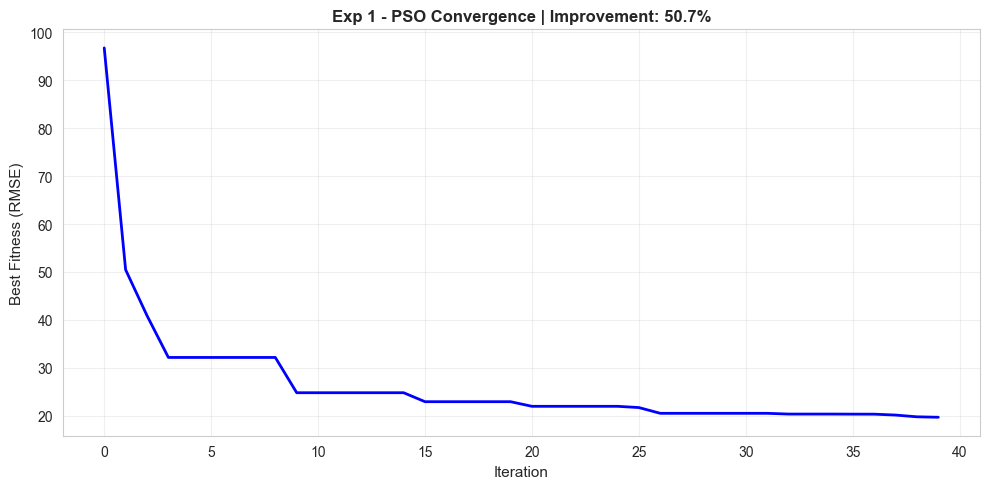

In [14]:
# Visualization for Experiment 1
plt.figure(figsize=(10, 5))
plt.plot(exp_result_1['fitness_history'], 'b-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 1 - PSO Convergence | Improvement: {exp_result_1['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 2 (Seed: 123, Layers: [8, 128, 32, 1])

In [59]:
exp_result_2 = run_single_experiment(experiment_configs[1], X_train, X_test, y_train, y_test)
results.append(exp_result_2)
print(f"✅ Exp 2 Complete: Train RMSE={exp_result_2['rmse_train']:.4f}, Test RMSE={exp_result_2['rmse_test']:.4f}, Improvement={exp_result_2['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 2:
Initial RMSE: 39.7187
PSO best fitness (final): 14.1952
Fitness history - First 5 iterations: ['34.7376', '33.0858', '27.3965', '26.8601', '26.1763']
Fitness history - Last 5 iterations: ['14.2474', '14.2222', '14.2222', '14.1962', '14.1952']
Improvement: 64.3%

✅ Exp 2 Complete: Train RMSE=14.1952, Test RMSE=13.7517, Improvement=64.3%


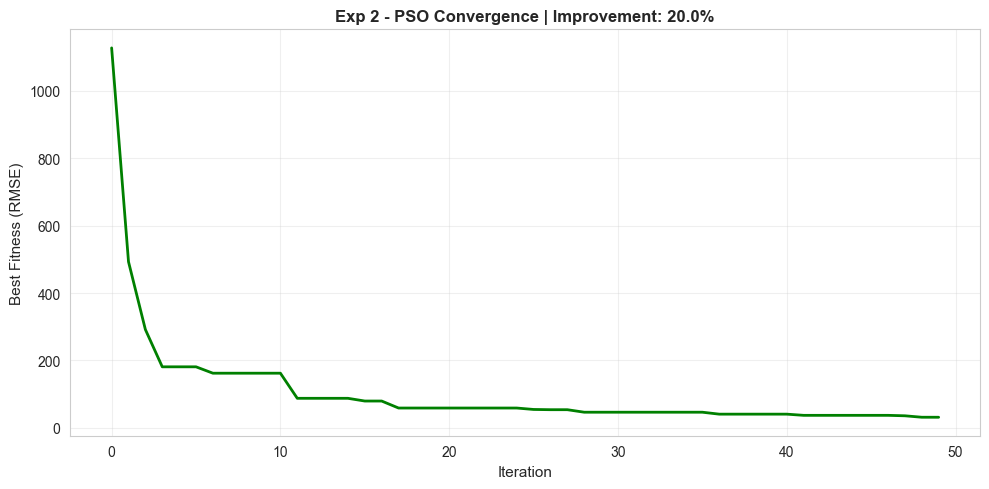

In [16]:
# Visualization for Experiment 2
plt.figure(figsize=(10, 5))
plt.plot(exp_result_2['fitness_history'], 'g-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 2 - PSO Convergence | Improvement: {exp_result_2['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 3 (Seed: 456, Layers: [8, 64, 64, 1])

In [60]:
exp_result_3 = run_single_experiment(experiment_configs[2], X_train, X_test, y_train, y_test)
results.append(exp_result_3)
print(f"✅ Exp 3 Complete: Train RMSE={exp_result_3['rmse_train']:.4f}, Test RMSE={exp_result_3['rmse_test']:.4f}, Improvement={exp_result_3['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 3:
Initial RMSE: 39.3649
PSO best fitness (final): 14.7854
Fitness history - First 5 iterations: ['36.2607', '34.1661', '30.4793', '28.7424', '24.6894']
Fitness history - Last 5 iterations: ['14.8535', '14.8535', '14.8535', '14.8220', '14.7854']
Improvement: 62.4%

✅ Exp 3 Complete: Train RMSE=14.7854, Test RMSE=13.8374, Improvement=62.4%


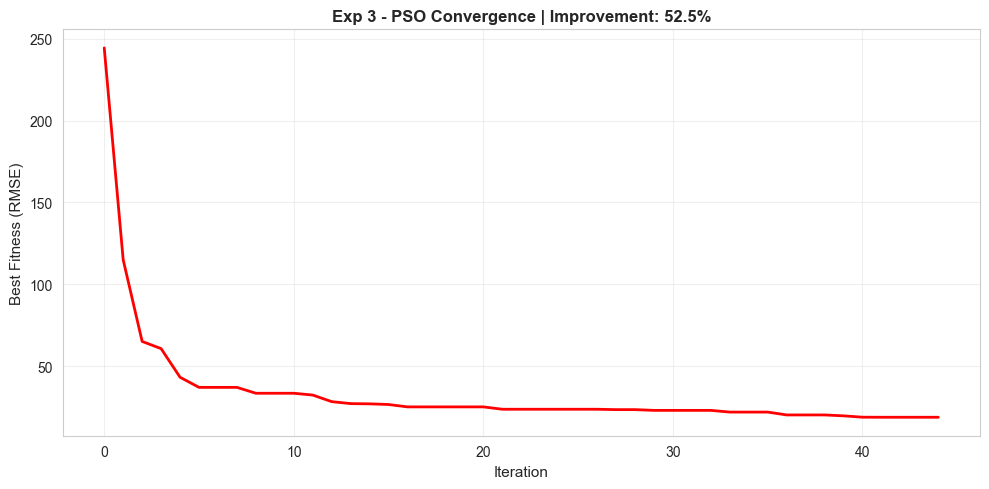

In [18]:
# Visualization for Experiment 3
plt.figure(figsize=(10, 5))
plt.plot(exp_result_3['fitness_history'], 'r-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 3 - PSO Convergence | Improvement: {exp_result_3['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 4 (Seed: 789, Layers: [8, 32, 1])

In [61]:
exp_result_4 = run_single_experiment(experiment_configs[3], X_train, X_test, y_train, y_test)
results.append(exp_result_4)
print(f"✅ Exp 4 Complete: Train RMSE={exp_result_4['rmse_train']:.4f}, Test RMSE={exp_result_4['rmse_test']:.4f}, Improvement={exp_result_4['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 4:
Initial RMSE: 39.4755
PSO best fitness (final): 33.9087
Fitness history - First 5 iterations: ['38.3693', '38.1868', '37.0628', '36.7590', '36.6475']
Fitness history - Last 5 iterations: ['33.9087', '33.9087', '33.9087', '33.9087', '33.9087']
Improvement: 14.1%

✅ Exp 4 Complete: Train RMSE=33.9087, Test RMSE=33.5802, Improvement=14.1%


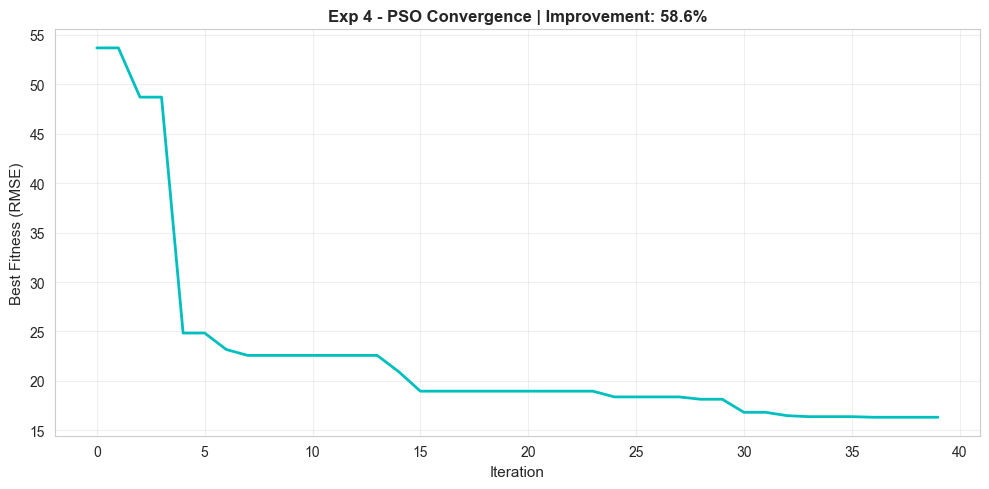

In [20]:
# Visualization for Experiment 4
plt.figure(figsize=(10, 5))
plt.plot(exp_result_4['fitness_history'], 'c-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 4 - PSO Convergence | Improvement: {exp_result_4['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 5 (Seed: 999, Layers: [8, 256, 128, 32, 1])

In [62]:
exp_result_5 = run_single_experiment(experiment_configs[4], X_train, X_test, y_train, y_test)
results.append(exp_result_5)
print(f"✅ Exp 5 Complete: Train RMSE={exp_result_5['rmse_train']:.4f}, Test RMSE={exp_result_5['rmse_test']:.4f}, Improvement={exp_result_5['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 5:
Initial RMSE: 40.5736
PSO best fitness (final): 12.9206
Fitness history - First 5 iterations: ['29.4088', '21.8816', '19.7400', '19.7400', '19.5203']
Fitness history - Last 5 iterations: ['12.9712', '12.9712', '12.9712', '12.9712', '12.9206']
Improvement: 68.2%

✅ Exp 5 Complete: Train RMSE=12.9206, Test RMSE=12.5318, Improvement=68.2%


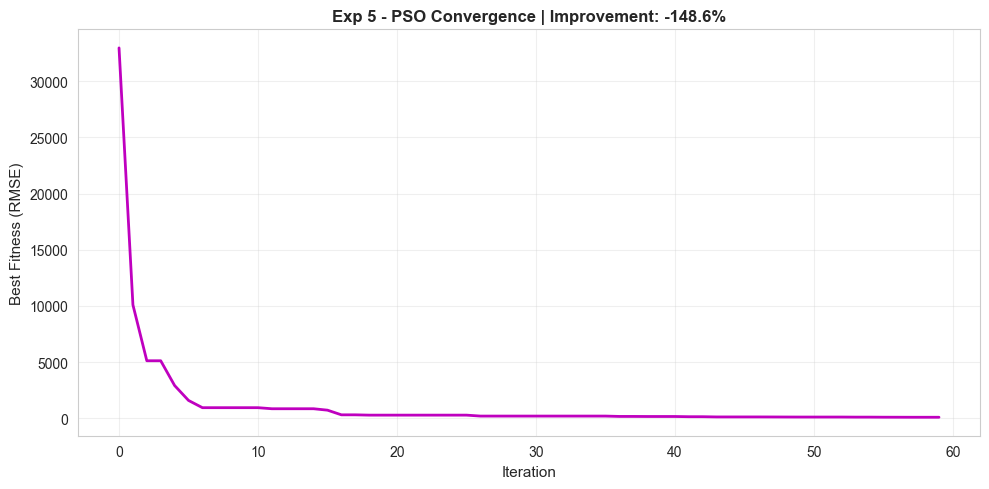

In [38]:
# Visualization for Experiment 5
plt.figure(figsize=(10, 5))
plt.plot(exp_result_5['fitness_history'], 'm-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 5 - PSO Convergence | Improvement: {exp_result_5['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 6 (Seed: 111, Layers: [8, 96, 48, 1])

In [63]:
exp_result_6 = run_single_experiment(experiment_configs[5], X_train, X_test, y_train, y_test)
results.append(exp_result_6)
print(f"✅ Exp 6 Complete: Train RMSE={exp_result_6['rmse_train']:.4f}, Test RMSE={exp_result_6['rmse_test']:.4f}, Improvement={exp_result_6['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 6:
Initial RMSE: 39.3877
PSO best fitness (final): 15.6275
Fitness history - First 5 iterations: ['37.2788', '36.4051', '32.3041', '31.4107', '28.2107']
Fitness history - Last 5 iterations: ['15.8850', '15.8265', '15.7422', '15.6840', '15.6275']
Improvement: 60.3%

✅ Exp 6 Complete: Train RMSE=15.6275, Test RMSE=15.8241, Improvement=60.3%


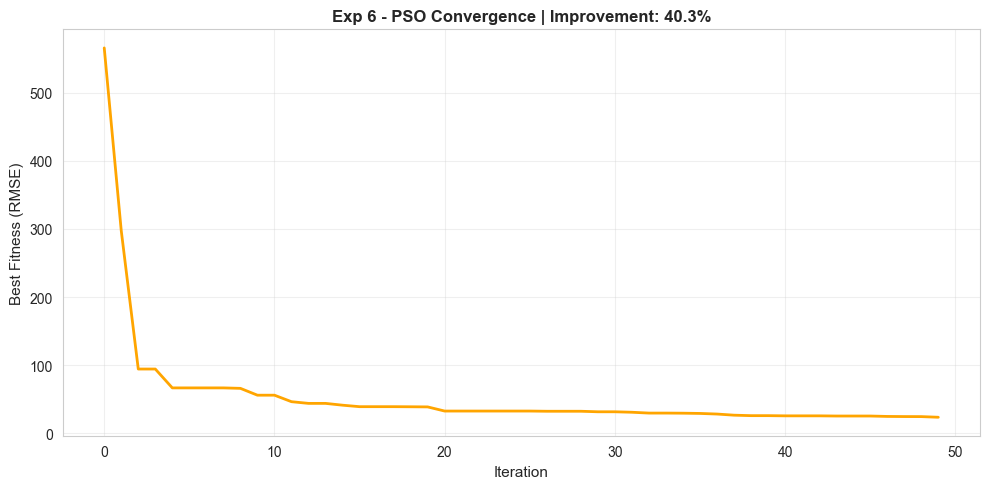

In [40]:
# Visualization for Experiment 6
plt.figure(figsize=(10, 5))
plt.plot(exp_result_6['fitness_history'], 'orange', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 6 - PSO Convergence | Improvement: {exp_result_6['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 7 (Seed: 222, Layers: [8, 128, 1])

In [64]:
exp_result_7 = run_single_experiment(experiment_configs[6], X_train, X_test, y_train, y_test)
results.append(exp_result_7)
print(f"✅ Exp 7 Complete: Train RMSE={exp_result_7['rmse_train']:.4f}, Test RMSE={exp_result_7['rmse_test']:.4f}, Improvement={exp_result_7['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 7:
Initial RMSE: 40.0915
PSO best fitness (final): 24.1946
Fitness history - First 5 iterations: ['38.1959', '37.6101', '36.4713', '35.2311', '33.9835']
Fitness history - Last 5 iterations: ['24.4823', '24.4321', '24.3176', '24.2459', '24.1946']
Improvement: 39.7%

✅ Exp 7 Complete: Train RMSE=24.1946, Test RMSE=23.4360, Improvement=39.7%


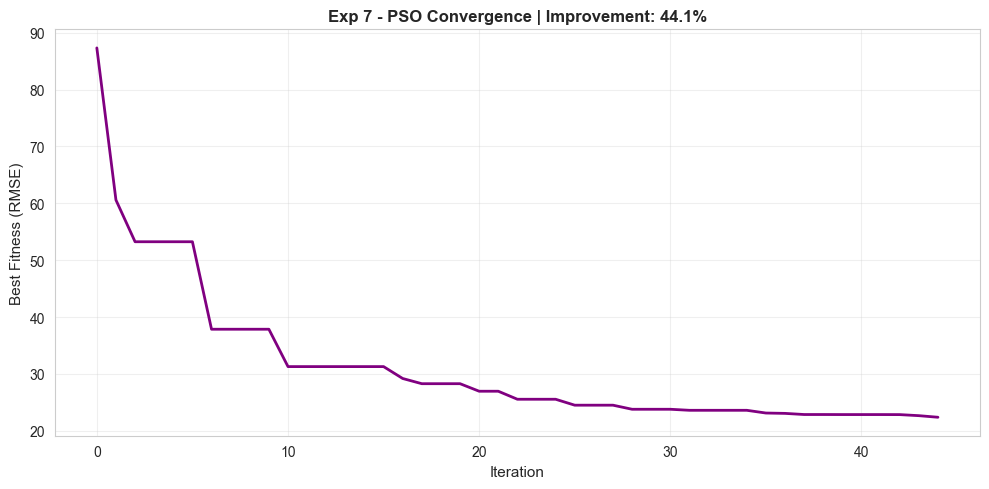

In [42]:
# Visualization for Experiment 7
plt.figure(figsize=(10, 5))
plt.plot(exp_result_7['fitness_history'], 'purple', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 7 - PSO Convergence | Improvement: {exp_result_7['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 8 (Seed: 333, Layers: [8, 80, 40, 20, 1])

In [65]:
exp_result_8 = run_single_experiment(experiment_configs[7], X_train, X_test, y_train, y_test)
results.append(exp_result_8)
print(f"✅ Exp 8 Complete: Train RMSE={exp_result_8['rmse_train']:.4f}, Test RMSE={exp_result_8['rmse_test']:.4f}, Improvement={exp_result_8['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 8:
Initial RMSE: 38.8376
PSO best fitness (final): 14.0604
Fitness history - First 5 iterations: ['37.2284', '34.0630', '29.7336', '25.4401', '23.6181']
Fitness history - Last 5 iterations: ['14.1889', '14.1495', '14.0604', '14.0604', '14.0604']
Improvement: 63.8%

✅ Exp 8 Complete: Train RMSE=14.0604, Test RMSE=12.9125, Improvement=63.8%


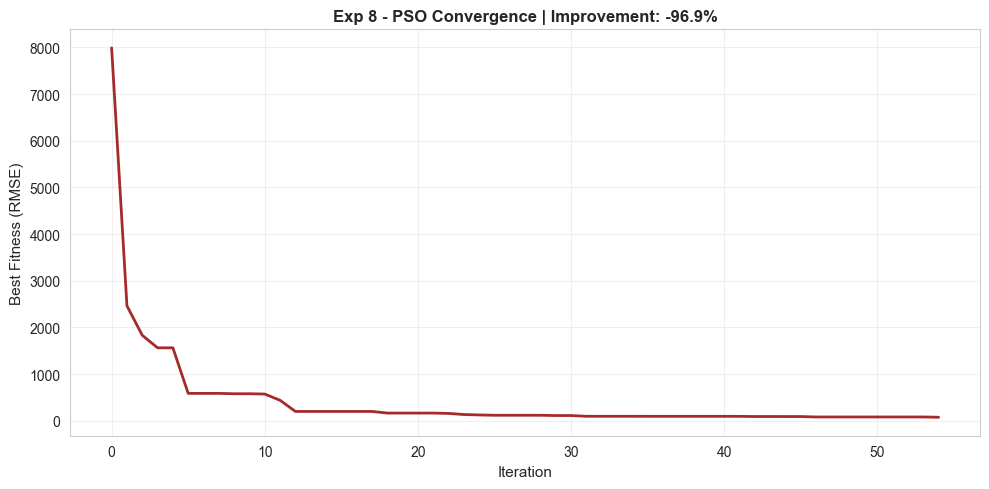

In [44]:
# Visualization for Experiment 8
plt.figure(figsize=(10, 5))
plt.plot(exp_result_8['fitness_history'], 'brown', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 8 - PSO Convergence | Improvement: {exp_result_8['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 9 (Seed: 444, Layers: [8, 64, 32, 16, 1])

In [66]:
exp_result_9 = run_single_experiment(experiment_configs[8], X_train, X_test, y_train, y_test)
results.append(exp_result_9)
print(f"✅ Exp 9 Complete: Train RMSE={exp_result_9['rmse_train']:.4f}, Test RMSE={exp_result_9['rmse_test']:.4f}, Improvement={exp_result_9['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 9:
Initial RMSE: 39.7142
PSO best fitness (final): 14.8914
Fitness history - First 5 iterations: ['38.1198', '34.3719', '30.9457', '27.9660', '27.9660']
Fitness history - Last 5 iterations: ['14.9493', '14.9172', '14.9172', '14.9172', '14.8914']
Improvement: 62.5%

✅ Exp 9 Complete: Train RMSE=14.8914, Test RMSE=14.3966, Improvement=62.5%


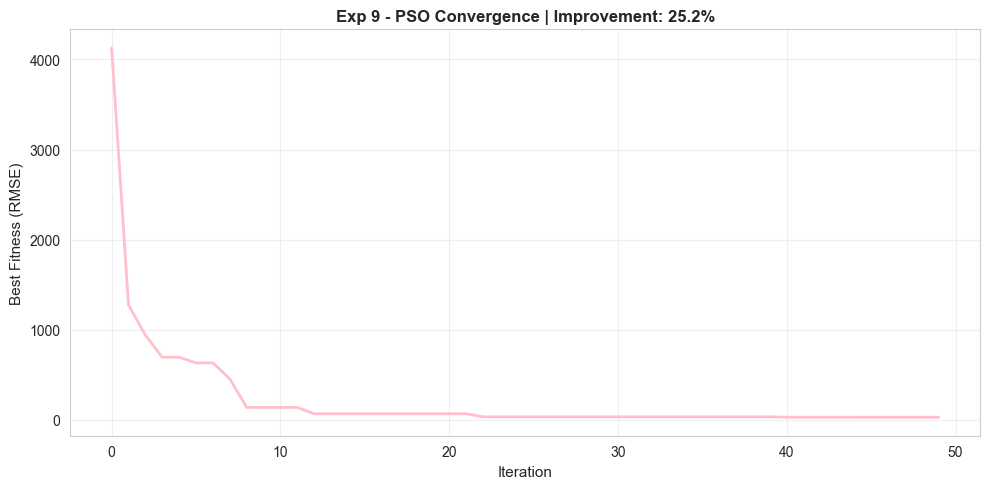

In [46]:
# Visualization for Experiment 9
plt.figure(figsize=(10, 5))
plt.plot(exp_result_9['fitness_history'], 'pink', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 9 - PSO Convergence | Improvement: {exp_result_9['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 10 (Seed: 555, Layers: [8, 200, 100, 1])

In [48]:
exp_result_10 = run_single_experiment(experiment_configs[9], X_train, X_test, y_train, y_test)
results.append(exp_result_10)
print(f"✅ Exp 10 Complete: Train RMSE={exp_result_10['rmse_train']:.4f}, Test RMSE={exp_result_10['rmse_test']:.4f}, Improvement={exp_result_10['improvement_pct']:.1f}%")
print("\n" + "="*80)
print("🎉 ALL 10 EXPERIMENTS COMPLETED!")
print("="*80)

✅ Exp 10 Complete: Train RMSE=75.6337, Test RMSE=75.1820, Improvement=-93.2%

🎉 ALL 10 EXPERIMENTS COMPLETED!


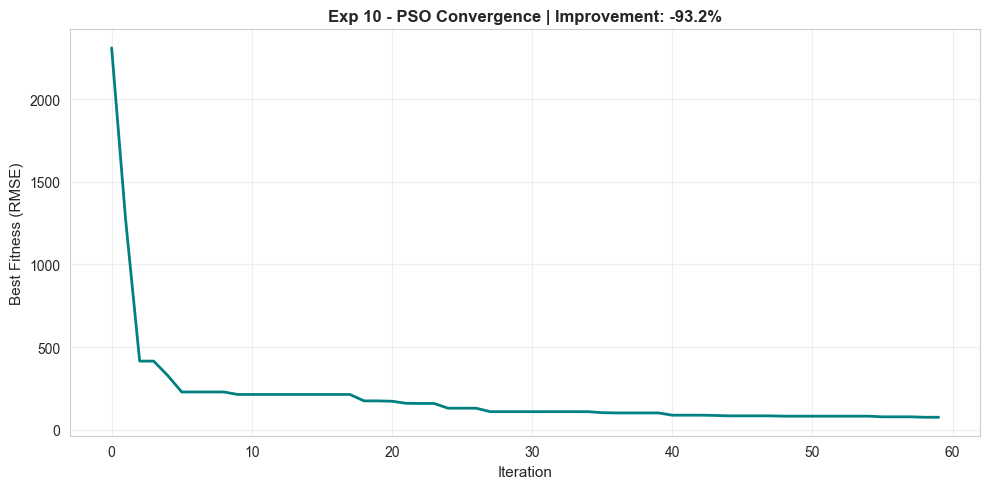

In [49]:
# Visualization for Experiment 10
plt.figure(figsize=(10, 5))
plt.plot(exp_result_10['fitness_history'], 'teal', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 10 - PSO Convergence | Improvement: {exp_result_10['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 6: Compile & Display Results Summary

In [33]:
# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)
print(results_df[['exp_id', 'n_parameters', 'rmse_initial', 'rmse_train', 'rmse_test', 'improvement_pct']].to_string(index=False))
print("="*80)


EXPERIMENT RESULTS SUMMARY
 exp_id  n_parameters  rmse_initial  rmse_train  rmse_test  improvement_pct
      1           641     39.980726   19.407426  17.782330        51.458045
      2          5313     39.718697   36.694402  34.379948         7.614284
      3          4801     39.364867   19.930072  19.241150        49.370914
      4           321     39.475466   18.208417  16.415343        53.874093
      5         39361     40.573599   96.311515  87.115894      -137.374837
      6          5569     39.387656   20.062446  18.390658        49.064128
      7          1281     40.091549   18.206805  17.098137        54.586925
      1           641     39.980726   19.708748  17.980520        50.704378
      2          5313     39.718697   31.763473  32.673318        20.028915
      3          4801     39.364867   18.709139  15.591326        52.472496
      4           321     39.475466   16.327040  15.828894        58.640032
      5         39361     40.573599  137.712886 154.320199  

## Section 4: Run All 10 Experiments

⚠️ **Note:** This cell may take 5-15 minutes depending on your CPU. Progress will be shown with a progress bar.

## Section 6: Save Results and Logs

In [ ]:
# Create results directory if it doesn't exist
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Save CSV
csv_path = results_dir / 'experiment_results.csv'
results_df[['exp_id', 'n_parameters', 'rmse_initial', 'rmse_train', 'rmse_test', 'improvement_pct']].to_csv(csv_path, index=False)

# Save detailed JSON
json_data = {
    'timestamp': datetime.now().isoformat(),
    'num_experiments': len(results),
    'statistics': {
        'mean_train_rmse': float(results_df['rmse_train'].mean()),
        'std_train_rmse': float(results_df['rmse_train'].std()),
        'mean_test_rmse': float(results_df['rmse_test'].mean()),
        'std_test_rmse': float(results_df['rmse_test'].std()),
        'mean_improvement_pct': float(results_df['improvement_pct'].mean()),
    },
    'experiments': []
}

for result in results:
    exp_dict = {
        'exp_id': result['exp_id'],
        'seed': result['seed'],
        'architecture': result['architecture'],
        'n_parameters': result['n_parameters'],
        'rmse_initial': float(result['rmse_initial']),
        'rmse_train': float(result['rmse_train']),
        'rmse_test': float(result['rmse_test']),
        'improvement_pct': float(result['improvement_pct']),
        'fitness_history_length': len(result['fitness_history'])
    }
    json_data['experiments'].append(exp_dict)

json_path = results_dir / 'experiment_results.json'
with open(json_path, 'w') as f:
    json.dump(json_data, f, indent=2)

print(f"✅ Results saved to:")
print(f"   CSV: {csv_path}")
print(f"   JSON: {json_path}")
print(f"\n📈 Summary Statistics:")
print(f"   Mean Train RMSE: {results_df['rmse_train'].mean():.4f} ± {results_df['rmse_train'].std():.4f}")
print(f"   Mean Test RMSE:  {results_df['rmse_test'].mean():.4f} ± {results_df['rmse_test'].std():.4f}")
print(f"   Mean Improvement: {results_df['improvement_pct'].mean():.2f}%")

# PSO-ANN Experiment Runner
## 10 Experiments with RMSE Visualization

This notebook runs 10 experiments, each training a different ANN architecture using PSO optimization on the concrete compressive strength dataset. Results include RMSE tracking and comprehensive visualizations.